## Lab 10, Part 1:   Convolutional Neural Networks (CNN) 

In this lab, we will learn how to train CNNs. All the code is provided. The code is allowing you to prepare the data and train a CNN that classifies which digit is written in an image provided at its input. We will show how you can train 4 different CNN, ranging from simple to more complex, and let you observe how it impacts classification accuracy. 

### MNIST Data Set

MNIST is a dataset of hand-written digits. Size of each image is 28 by 28 pixels, where each pixel has values between 0 (white) and 255 (black). 

CNN training can take quite a bit of time (particularly if GPU isn't used), so we will create a training data set that uses a subset of available data. In particular, we will define the classification problem as recognizing whether a digit in an image is 7 or not. The following piece of code shows the data preparation steps.

In [202]:
#Import the required libraries
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

The following block selects a subset of images from the MNIST data.

In [203]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_orig = X_test

# Select the subset from the train data for the sake of time.
np.random.seed(1338)  # for reproducibilty!!
# The subset is composed of all the examples where the digit is 7, and 20,000 examples are not 7.
sevens = np.where(y_train == 7)[0].tolist()
not_sevens = np.where(y_train != 7)[0].tolist()
num_keepers = 20000
not_sevens = np.random.choice(not_sevens, num_keepers, replace=False).tolist()

subset = sevens + not_sevens
np.random.shuffle(subset) # shuffle the input

X_train = X_train[subset, :, :]
y_train = y_train[subset]

The following code creates training and test data. It would be great if you can spend a few minutes trying to understand what is going on.

In [204]:
from keras import backend as K # import the tensor manipulation library (in our case tensorflow)

img_rows, img_cols = 28, 28  # deciding pixels size

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)
    
# Normalize the images:

# Reshapes the images into shape of (# of rows of original matrices, 28, 28, 1)
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

# converts all numbers into float type
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# because the values are out of 0 (white) to 255 (black) color values, we want the ones with black color values
X_train /= 255
X_test /= 255

# Create labels:

# Converting the labels to binary classification(Seven =1,Not Seven=0)
Y_train = (y_train == 7).astype(int)
Y_test = (y_test == 7).astype(int)

# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
# the train and test matrices become (# of rows x nb_classes) size matrices
# with booleans T and F represented by 1.0 and 0 

**Question 1.** What are the dimensions of X_train, X_test, Y_train and Y_test? What are ranges of numbers in each of those?

In [205]:
print('Size of X_train:', np.shape(X_train))
print('Size of X_test:',np.shape(X_test))
print('Size of Y_train:',np.shape(Y_train))
print('Size of Y_test:',np.shape(Y_test))
print('Range of X_train:', X_train.max()-X_train.min())
print('Range of X_test:', X_test.max()-X_test.min())
print('Range of Y_train:', Y_train.max()-Y_train.min())
print('Range of Y_test:', Y_test.max()-Y_test.min())

Size of X_train: (26265, 28, 28, 1)
Size of X_test: (10000, 28, 28, 1)
Size of Y_train: (26265, 2)
Size of Y_test: (10000, 2)
Range of X_train: 1.0
Range of X_test: 1.0
Range of Y_train: 1.0
Range of Y_test: 1.0


### Train a simple CNN (CNN, model 1)

The following code will show how you can define CNN, train it, and test its accuracy. 

**Step 0.** The following is a preparation step, specifying the hyperparameters.

In [206]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

**Step 1.** In this step we define architecture of the CNN

Each line "model.add()" adds another layer to the neural network. The type of layer must be specified. 

In [207]:
# from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(26, 26)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

We can check the configuration of the above model by call model.summary()

In [208]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_126 (Activation)  (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_127 (Activation)  (None, 2)                 0         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


**Question 2.** From the above summary, can you explain the architecture of this CNN?

**Answer 2:** <br>
The model architecture of this CNN starts with a 2D image convolution layer which is initiated with a 3 by 3 kernel size (aka a 3 by 3 matrix) using nb_filters (32) number of filters. There are 6 layers in total ending with an activation layer. The first output shape is 26 by 26 because of the stride and padding we learned in class which tells us that as the convolution moves along the image (in our case 28 by 28 pixels) it doesn't get to move along the full image and sometimes there are 1 column and 1 row "lost" in the output shape. Also shown here is that there are 32 activation maps stacked together making each stack with 10 new weights according to params. Next with Activation the output is repeated and there are no new params as it was "relu" resulting in one-to-one output this time. Then pooling layer returns a 32 stack of a 1 by 1 matrix of the highest number within each outputted activation stack. Flatten layer does what its name says, the 32 stacks are flattened into 1 single vector hence output is $1*1*32 = 32$. Afterwards the dense layer is applied which multiples all values by nb_classes effecting 66 new weights. Lastly, one more activation layer which outputs no new weights again. In total there are 386 weights produced.

**Step 2.** Here, we define the loss function. You will see that the loss function is not Mean Square Error, but Cross Entropy. Cross Entropy is a very popular choice when training neural networks for classification problems.

In [209]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

**Step 3.** This line of code trains CNN. This is going to take about a minute. Observe that we will only have 2 epochs of training, in the interest of time. You will see how the accuracy on training and validation data evolves during training.

In [216]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=10, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/10
26265/26265 [==============================] - 7s 272us/step - loss: 0.2135 - acc: 0.9236 - val_loss: 0.1056 - val_acc: 0.9663
Epoch 2/10
26265/26265 [==============================] - 7s 281us/step - loss: 0.2036 - acc: 0.9275 - val_loss: 0.3118 - val_acc: 0.8669
Epoch 3/10
26265/26265 [==============================] - 7s 254us/step - loss: 0.1922 - acc: 0.9307 - val_loss: 0.1084 - val_acc: 0.9630
Epoch 4/10
26265/26265 [==============================] - 8s 301us/step - loss: 0.1849 - acc: 0.9324 - val_loss: 0.0939 - val_acc: 0.9679
Epoch 5/10
26265/26265 [==============================] - 10s 370us/step - loss: 0.1790 - acc: 0.9353 - val_loss: 0.1085 - val_acc: 0.9622
Epoch 6/10
26265/26265 [==============================] - 8s 298us/step - loss: 0.1821 - acc: 0.9333 - val_loss: 0.1953 - val_acc: 0.9243
Epoch 7/10
26265/26265 [==============================] - 11s 405us/step - loss: 0.1784 - acc: 0.9344 - val_loss: 0.1045 

Let us plot the accuracy. 

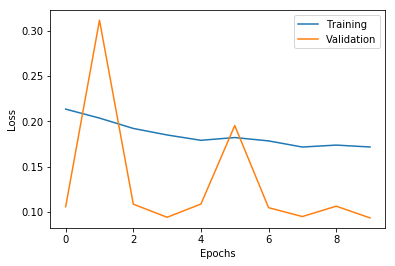

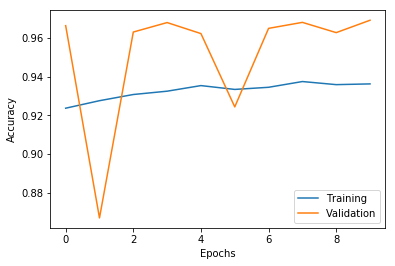

In [217]:
import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure()
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

**Step 4.** Evaluate the accuracy on test data.

In [218]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.0931921156488359
Test Accuracy: 0.9691


Let us visualize our model Predictions!

In [219]:
import matplotlib.pyplot as plt

%matplotlib inline

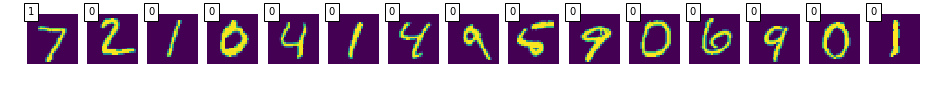

In [220]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

**Question 3.** Can you discuss the performance of the CNN model? What kind of errors is it making?

In [221]:
print(hist.history)

{'val_loss': [0.10560596122741699, 0.31180652072429654, 0.10841639751791954, 0.09389599697142839, 0.10854626082777977, 0.1953279242515564, 0.10451839736402035, 0.09469837929829955, 0.10617973331212997, 0.09319211684539914], 'val_acc': [0.9663, 0.8669, 0.963, 0.9679, 0.9622, 0.9243, 0.9649, 0.968, 0.9627, 0.9691], 'loss': [0.21351587186875445, 0.20359931773806264, 0.1921527117048244, 0.18492262726871259, 0.17902489304173771, 0.18206765341425132, 0.17836659556453668, 0.17157672204938182, 0.17373557028068307, 0.17163188221738346], 'acc': [0.9236245954851412, 0.9275080906307722, 0.9307062630673352, 0.932419569785541, 0.9353131543675446, 0.9333333333492189, 0.9344374643061107, 0.9374071958631011, 0.9358081096675132, 0.9361888444698268]}


Because we chose to use "categorical_crossentropy", the outputs are binary (either 1 or 0) to categorize whether this image is a 7 or not. From just looking at the test output images, the convolution network is making errors when some of the images have parts that look like a 7. For example the bottom portion of the number 4 or 9. The way that the 5 was written here also makes it visually skew into a 7. I found through the API that you can print out the loss and accuracy of every epoch. So, looking at it we have both the validation and normal training losses and accuracies. Looking at all three pairs of loss/accuracy (test included in part 4), the convolution network performs poorly as it has low accuracy and high loss while evaluating the test data.

**Question 4.** Run the training for 10 epochs. How did it impact the accuracy?

After running the epoch for 10 times, the accuracy improves drastically! Even the testing accuracy is up to 0.9695 compared to previously where it was somewhere in the 0.60s. This is as expected since with every epoch run the algorithm should improve in accuracy for it to be a machine learing algorithm and classify the images better according to the weights.

### Train a more complicated CNN (CNN, model 2)

Now, we will define a more complicated CNN architecture.

In [222]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [223]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_128 (Activation)  (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               692352    
_________________________________________________________________
activation_129 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 258       
__________

In [224]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=10,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/10
26265/26265 [==============================] - 16s 616us/step - loss: 0.1961 - acc: 0.9274 - val_loss: 0.0920 - val_acc: 0.9724
Epoch 2/10
26265/26265 [==============================] - 13s 489us/step - loss: 0.0921 - acc: 0.9694 - val_loss: 0.0630 - val_acc: 0.9804
Epoch 3/10
26265/26265 [==============================] - 13s 480us/step - loss: 0.0807 - acc: 0.9730 - val_loss: 0.0693 - val_acc: 0.9774
Epoch 4/10
26265/26265 [==============================] - 16s 598us/step - loss: 0.0745 - acc: 0.9754 - val_loss: 0.0683 - val_acc: 0.9775
Epoch 5/10
26265/26265 [==============================] - 13s 514us/step - loss: 0.0697 - acc: 0.9768 - val_loss: 0.0664 - val_acc: 0.9780
Epoch 6/10
26265/26265 [==============================] - 14s 522us/step - loss: 0.0659 - acc: 0.9784 - val_loss: 0.0510 - val_acc: 0.9840
Epoch 7/10
26265/26265 [==============================] - 11s 432us/step - loss: 0.0623 - acc: 0.9795 - val_loss: 0.

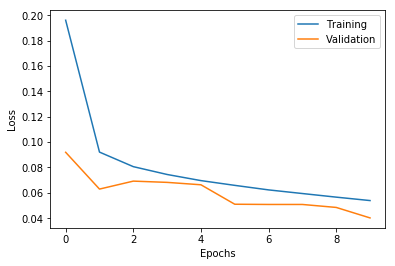

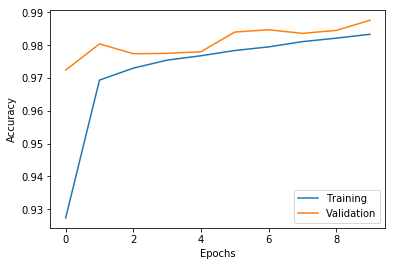

In [228]:
plt.figure()
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

In [229]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.040262175358552484
Test accuracy: 0.9876


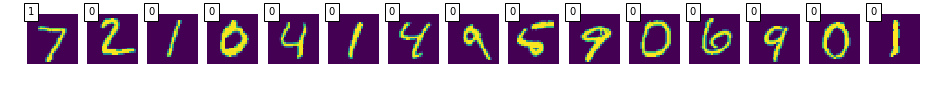

In [230]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Wow! We have lifted the accuracy from 70.4% to 97.8%. This model can figure out the two "4"s  are not 7, but still be confused by pesky "9"! 

**Question 5.** Can you explain the architecture of this CNN (model 2) and how is it different from the first CNN you trained (model 1)? Compare their performance by looking at the visualizstions.

There are several differences in these CNN models. First and foremost, model 2 has 2 extra layers compared to model 1. The two extra layers are an extra activation and dense layer respectively. The pooling layers are also different as we use a 2 by 2 matrix to evaluate 13 max values from the stacks of activation mapped matrices. Hence the single vector created from the flatten layer now has A LOT more values than the original model 1. Also after applying the dense layer which had an input of 128 instead of 2, there are 692352 new weights now. Hence this affects model 2 to become better as there are more weights to train which will lead to a better NN that can evaluate differences between 7s and not 7s. If I were to compare the initial performances of models 1 and 2, the second model immediately does better at the starting point with an accuracy of close to 0.98 compared to first model's initial 0.71 accuracy. Model 2's original graphical representation of loss was a steep downwards slope with a positive slope of accuracy while model 1 had a visibly less steep downwards and upwards slope for loss and accuracy respectively. Even after running both models again for 10 epochs, the **second** model does better with an accuracy reaching 0.99. The validation data is "weird" here as both of their graphical visualizations show fluctuations.

### Adding more convolutional layers and MaxPooling layers (CNN, model 3)

Now, we will define an even more complicated CNN architecture.

In [231]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [232]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_131 (Activation)  (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 1602      
__________

In [233]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 19s 718us/step - loss: 0.2484 - acc: 0.9017 - val_loss: 0.0978 - val_acc: 0.9735
Epoch 2/2
26265/26265 [==============================] - 15s 559us/step - loss: 0.1068 - acc: 0.9627 - val_loss: 0.0735 - val_acc: 0.9766


In [234]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.07347161663770675
Test accuracy: 0.9766


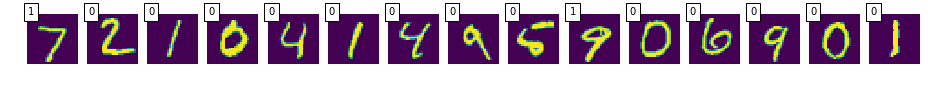

In [235]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Another 0.2 % lift from 97.8% to 98.0%. This model sees clearly "9" is different than "7"! 

### Wrapping all the code together and play with hyperparameters

The code below wraps up the pieces of codes above into a single function and allows you to play with the hyperparameters by changing the arguments.


In [236]:
# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model(num_conv = 1, conv_activation = "relu", num_dense = 1, dense_activation  = "relu", 
               dropout = True, max_pooling = True):
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation(conv_activation))
    
    for i in range(num_conv-1):
        model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
        model.add(Activation(conv_activation))
        
    if max_pooling is True:
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        
    if dropout is True:
        model.add(Dropout(0.25))
    
    model.add(Flatten())

    if dropout is True:
        model.add(Dropout(0.5))
    
    for i in range(num_dense-1):
        model.add(Dense(128))
        model.add(Activation(dense_activation))
        
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(num_conv , 'convolutional layers,', num_dense, "dense layers")
    if max_pooling: print("With max pooling")
    if dropout: print("With dropout")
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)

    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

An example of running this function

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 13s 508us/step - loss: 0.2254 - acc: 0.9165 - val_loss: 0.0905 - val_acc: 0.9757
Epoch 2/2
26265/26265 [==============================] - 11s 421us/step - loss: 0.1194 - acc: 0.9585 - val_loss: 0.0790 - val_acc: 0.9770
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.07904098340272904
Test accuracy: 0.977


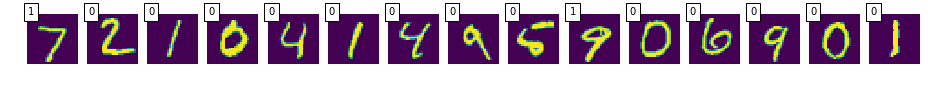

In [237]:
# Here is an example of running build_model() with default hyperparameters
build_model()

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 88s 3ms/step - loss: 0.2727 - acc: 0.8804 - val_loss: 0.0711 - val_acc: 0.9774
Epoch 2/2
26265/26265 [==============================] - 88s 3ms/step - loss: 0.1168 - acc: 0.9595 - val_loss: 0.0607 - val_acc: 0.9815
3 convolutional layers, 3 dense layers
With max pooling
With dropout
Test score: 0.06071068272441626
Test accuracy: 0.9815


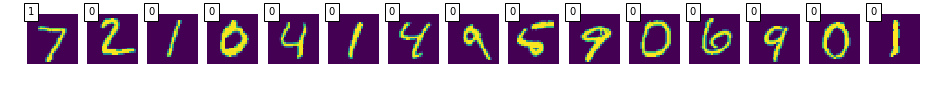

In [238]:
# Here is an example of running build_model() with new hyperparameters
build_model(num_conv = 3, num_dense = 3)

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 12s 474us/step - loss: 0.2333 - acc: 0.9119 - val_loss: 0.0856 - val_acc: 0.9774
Epoch 2/2
26265/26265 [==============================] - 12s 467us/step - loss: 0.1224 - acc: 0.9566 - val_loss: 0.0711 - val_acc: 0.9800
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.07114433366283775
Test accuracy: 0.98
27.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


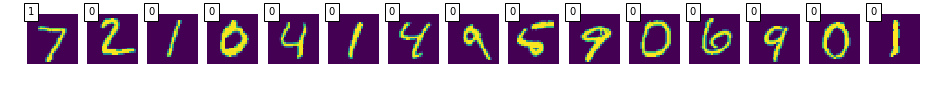

In [239]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

**Question 6.** Try to change some of the **hyperparameters** without exploding the computational resources on your computer. 
What is the best accuracy you can get? How many parameters are there of each model? How long does the training take? Maybe increase the amount of data used? What does that do to the accuracy and training time? 

Train on 26265 samples, validate on 10000 samples
Epoch 1/2
26265/26265 [==============================] - 80s 3ms/step - loss: 0.2266 - acc: 0.9025 - val_loss: 0.0965 - val_acc: 0.9649
Epoch 2/2
26265/26265 [==============================] - 79s 3ms/step - loss: 0.0784 - acc: 0.9726 - val_loss: 0.0464 - val_acc: 0.9853
3 convolutional layers, 3 dense layers
With max pooling
Test score: 0.04641162210144103
Test accuracy: 0.9853
2min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


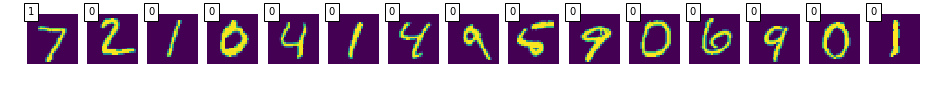

In [250]:
%timeit -n1 -r1 build_model(num_conv = 3, conv_activation = "relu", num_dense = 3, dense_activation  = "relu", dropout = False, max_pooling = True)

Comparing to the original build_model() with its default hyperparameters, I added another 2 layers of Convolutional and Dense layers and also setting dropout to `False.` This improved the accuracy compared to the original but not by a lot. The highest run I got after quite a few runs was 98.53%, but this accurcy itself also fluctuates. By setting dropout to be false, that already added data being used throughout the CNN model as we do not drop any fraction of input units. It does increase the accuracy but like I said the accuracy fluctuates and this is due chances of overfitting as we learned in class. Not dropping any inputs throughout each update of training time also means that the training time takes longer as there's more data running through the algorithm compared to the default model which had dropout set to True. I also did experiment using other activation functions like `sigmoid, tanh, and elu` but none of them increased the accuracy. Some of them even slowered the training tremendously. With the hyperparameters I currently use as my "best accuracy", the average training time is already at 2 minutes and 46 seconds for 2 epochs. 

#### Question 7 (20% of the grade)

Can you train a model to output 10 classes instead of 2 binary classes? We can use this model to classify images into 10 digits of the mnist data set. Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 digits present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

Train on 20000 samples, validate on 10000 samples
Epoch 1/2
20000/20000 [==============================] - 10s 507us/step - loss: 1.4427 - acc: 0.5843 - val_loss: 0.5963 - val_acc: 0.8471
Epoch 2/2
20000/20000 [==============================] - 8s 399us/step - loss: 0.6004 - acc: 0.8157 - val_loss: 0.4122 - val_acc: 0.8864
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 0.41216935865879056
Test accuracy: 0.8864


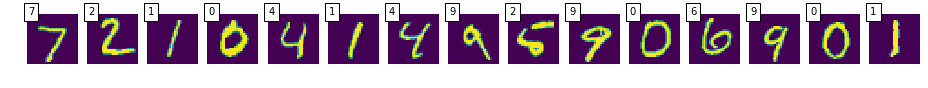

In [165]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test_orig = X_test

np.random.seed(1388) # for reproducibility again
# Since mnist.load_data automatically loads images of 10 different digits, no need to use np.where
# Reusing the code I made from lab 7 to create the list of 20,000 row indexes out of 60000 possible indexes
subset = []
while len(subset) != 20000:
    random_int = np.random.randint(60000)
    if random_int not in subset: subset.append(random_int)
#print('Double checking length:', len(subset))

X_train = X_train[subset, :, :]
y_train = y_train[subset]

img_rows, img_cols = 28, 28  # deciding pixels size

if K.image_data_format() == 'channels_first':     # I already know from the previous example it's channel_last
    shape_ord = (1, img_rows, img_cols)           # Adding just because I don't want to risk I'm missing anything
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)
    
## Repeating the image processing
# Normalize the images:

# Reshapes the images into shape of (# of rows of original matrices, 28, 28, 1)
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

# converts all numbers into float type
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# because the values are out of 0 (white) to 255 (black) color values, we want the ones with black color values
X_train /= 255
X_test /= 255

# Create labels:
# Converting the classes to its binary categorical form
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
# the train and test matrices become (# of rows x nb_classes) size matrices
# with booleans T and F represented by 1.0 and 0 

## Double checking the to_categorical is correct
#print(y_train[0])
#print(Y_train[0])
build_model()

#### Question 8 (30% of the grade) 

Train a model on CIFAR10 dataset, which is described in https://www.cs.toronto.edu/~kriz/cifar.html. You can load the dataset from Keras, too. CIFAR10 small image classification contains 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

```python
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
```

Again, we will only train our model on a subset of the training data. The following steps will help you to build such a model.

    * 1. Select 20,000 examples randomly from X_train, since we want all 10 categories present in our training data.
    * 2. Convert Y_train and Y_test to categorical.
    * 3. Call the build_model() on the X_train and Y_train.

Train on 20000 samples, validate on 10000 samples
Epoch 1/2
20000/20000 [==============================] - 16s 810us/step - loss: 2.1768 - acc: 0.1985 - val_loss: 2.0095 - val_acc: 0.3048
Epoch 2/2
20000/20000 [==============================] - 15s 771us/step - loss: 1.9873 - acc: 0.2899 - val_loss: 1.9075 - val_acc: 0.3463
1 convolutional layers, 1 dense layers
With max pooling
With dropout
Test score: 1.907505908203125
Test accuracy: 0.3463


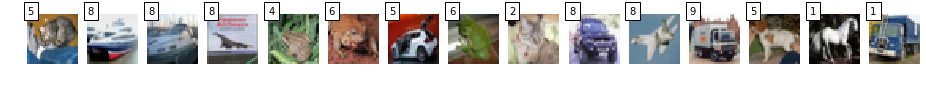

In [166]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_test_orig = X_test

## Pretty much similar to the above code except with slight changes where the images are now of size 32 x 32 pixels.
## Also the parameter of random int is changed to 50000, as the data set has at most 50,000 images. 
## Lastly, the shape of the images are originally (num_samples, 3, 32, 32)

np.random.seed(1388) # for reproducibility again
# Since mnist.load_data automatically loads images of 10 different digits, no need to use np.where
# Reusing the code I made from lab 7 to create the list of 20,000 row indexes out of 60000 possible indexes
subset = []
while len(subset) != 20000:
    random_int = np.random.randint(50000)
    if random_int not in subset: subset.append(random_int)
#print('Double checking length:', len(subset))

X_train = X_train[subset, :, :]
y_train = y_train[subset]

img_rows, img_cols = 32, 32  # deciding pixels size

if K.image_data_format() == 'channels_first':     # I already know from the previous example it's channel_last
    shape_ord = (3, img_rows, img_cols)           # Adding just because I don't want to risk I'm missing anything
else:  # channel_last
    shape_ord = (img_rows, img_cols, 3)
    
## Repeating the image processing
# Normalize the images:

X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

# converts all numbers into float type
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# because the values are out of 0 (white) to 255 (black) color values, we want the ones with black color values
X_train /= 255
X_test /= 255

# Create labels:
# Converting the classes to its binary categorical form
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
# the train and test matrices become (# of rows x nb_classes) size matrices
# with booleans T and F represented by 1.0 and 0 

## Double checking the to_categorical is correct
#print(y_train[0])
#print(Y_train[0])
build_model()

Since the accuracy for the classification of CIFAR10 dataset turned out so poorly, I'm attempting to improve it by changing the hyperparameters.

In [176]:
build_model(num_conv = 2, conv_activation = "tanh", num_dense = 2, dense_activation  = "tanh", 
               dropout = False, max_pooling = True)

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/step - loss: 2.0650 - acc: 0.2471 - val_loss: 1.9086 - val_acc: 0.3326
Epoch 2/10
20000/20000 [==============================] - 55s 3ms/step - loss: 1.8488 - acc: 0.3448 - val_loss: 1.7450 - val_acc: 0.4057
Epoch 3/10
20000/20000 [==============================] - 52s 3ms/step - loss: 1.7471 - acc: 0.3831 - val_loss: 1.6996 - val_acc: 0.4092
Epoch 4/10
20000/20000 [==============================] - 54s 3ms/step - loss: 1.6771 - acc: 0.4108 - val_loss: 1.6096 - val_acc: 0.4417
Epoch 5/10
 5248/20000 [======>.......................] - ETA: 36s - loss: 1.6110 - acc: 0.4278

KeyboardInterrupt: 

After testing out a few different hyperparameters I found that the example given above gave the best performance right off the bat, meaning at the very first epoch the model already outputted better accuracy than the base model that was given with `num_conv = 1`, `num_dense = 1`, `activation = relu`, and `dropout = True`. I'm guessing these are attributed to the fact that the images have different pixel values as each image comes with a distinct photo of the category they're under. The categories being airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck according to the website. Looking at those examples on the site alone already show how the different images with different colors makes it even harder to classify with high accuracy due to the difference in pixel values and we divided by 255 to break down between black and white. However, I realize this might be the very issue where if I am able to better divide the image colors into their separate R,B,G values then that would've helped improved accuracy. I tried looking online how to improve this but found no luck on the matter.